In [35]:
# %% 0) Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set_context("talk"); plt.rcParams["figure.figsize"] = (9,6)
plt.rcParams["axes.spines.top"] = plt.rcParams["axes.spines.right"] = False

DATA_PATH = "data/synthetic/synthetic_cs2019_from_seq_regs_stdnames.parquet"   # <- change if needed
OUT = Path("figs"); OUT.mkdir(exist_ok=True)

# load (csv or parquet)
df = pd.read_parquet(DATA_PATH) if DATA_PATH.endswith(".parquet") else pd.read_csv(DATA_PATH)
df = df.replace([np.inf,-np.inf], np.nan)

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]


In [37]:
df.columns

Index(['firm_id', 'year', 'county', 'firm_owner', 'nace2', 'nace3', 'nace4',
       'age', 'tangible_assets_1000HUF', 'sales_1000HUF', 'profit_1000HUF',
       'personal_expenses_1000HUF', 'eq_ratio', 'export_value_1000HUF',
       'EBIT_1000HUF', 'has_subsidy', 'grant_1000HUF'],
      dtype='object')

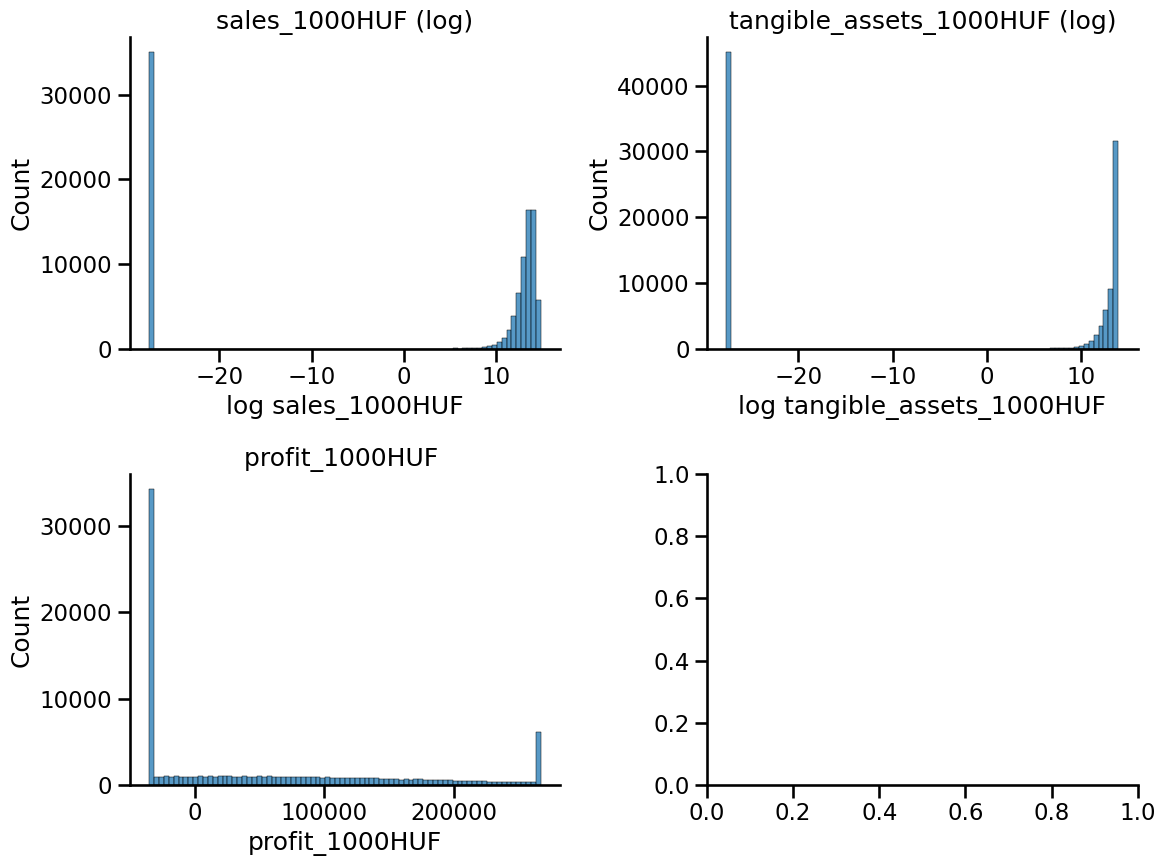

In [38]:
# %% 1) Histograms (log scale where heavy-tailed)
vars1 = ["sales_1000HUF","tangible_assets_1000HUF","profit_1000HUF"]
fig, axes = plt.subplots(2,2, figsize=(12,9))
for ax, v in zip(axes.ravel(), vars1):
    x = df[v].dropna()
    log = (x.max()/x.replace(0,np.nan).min() > 200)
    sns.histplot(np.log(x.clip(1e-12)) if log else x, ax=ax, bins=80)
    ax.set_title(f"{v} " + ("(log)" if log else ""))
    ax.set_xlabel(("log " if log else "") + v)
plt.tight_layout(); plt.savefig(OUT/"01_histograms.png", dpi=160); plt.show()


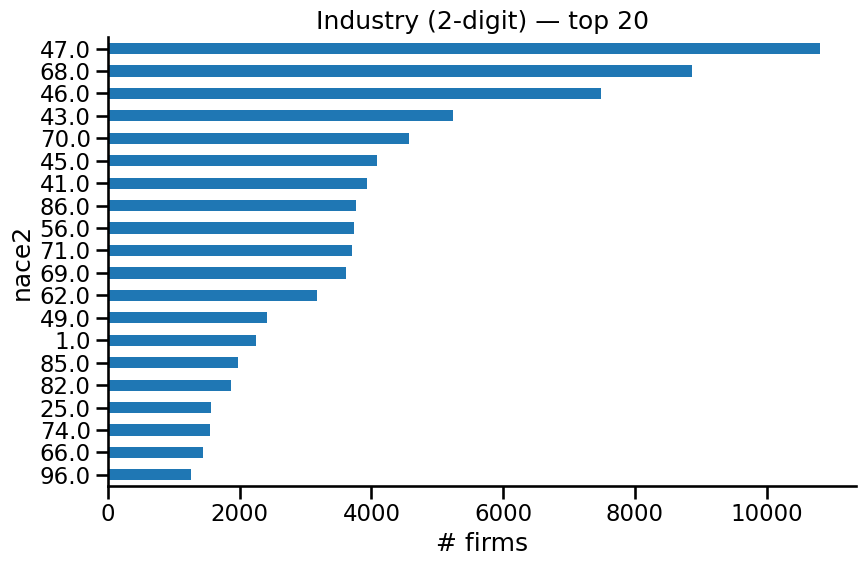

In [41]:
# %% 2) Industry frequency (bar, top 20)
if "nace2" in df.columns:
    ct = (df["nace2"].astype(str)
          .value_counts().head(20).sort_values(ascending=True))
    ct.plot(kind="barh")
    plt.title("Industry (2-digit) — top 20"); plt.xlabel("# firms")
    plt.tight_layout(); plt.savefig(OUT/"02_freq_industry.png", dpi=160); plt.show()


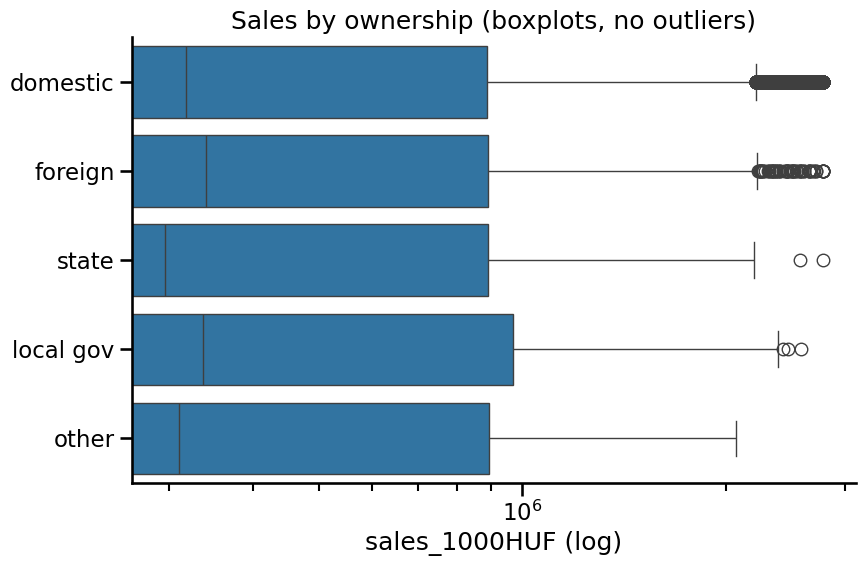

In [ ]:
# %% 4) Boxplots of sales by ownership (log scale on x)
if {"firm_owner","sales_1000HUF"}.issubset(df.columns):
    fig, ax = plt.subplots()
    sns.boxplot(data=df, x="sales_1000HUF", y="firm_owner", showfliers=True)
    ax.set_xscale("log"); ax.set_xlabel("sales_1000HUF (log)"); ax.set_ylabel("")
    ax.set_title("Sales by ownership (boxplots, with outliers)")
    plt.tight_layout(); plt.savefig(OUT/"04_box_sales_ownership.png", dpi=160); plt.show()


## Food panel

In [51]:
# %% 0) Setup & load
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.spines.top"] = plt.rcParams["axes.spines.right"] = False

DATA_PATH = "data/synthetic/panel_food_simulated.parquet"  # change if needed
OUT = Path("figs_panel"); OUT.mkdir(exist_ok=True)

df = pd.read_parquet(DATA_PATH) if DATA_PATH.endswith(".parquet") else pd.read_csv(DATA_PATH)
df = df.replace([np.inf,-np.inf], np.nan)

# ---- your varnames ----
sales, emp, totA, tanA, perE = "sales_clean","emp","eszk","tanass_clean","persexp_clean"
pm, profit, ebit = "pm","pretax","ereduzem"
exportv, exporter = "export","has_export"
county, owner, ind2 = "county","firm_owner","nace2"

# keep industry '10' if column present
if ind2 in df.columns:
    df = df[df[ind2].astype(str) == "10"]

years = sorted(df["year"].unique())
have = set(df.columns)


In [67]:
years

[np.int64(2010),
 np.int64(2011),
 np.int64(2012),
 np.int64(2013),
 np.int64(2014),
 np.int64(2015),
 np.int64(2016),
 np.int64(2017),
 np.int64(2018),
 np.int64(2019),
 np.int64(2020),
 np.int64(2021),
 np.int64(2022)]

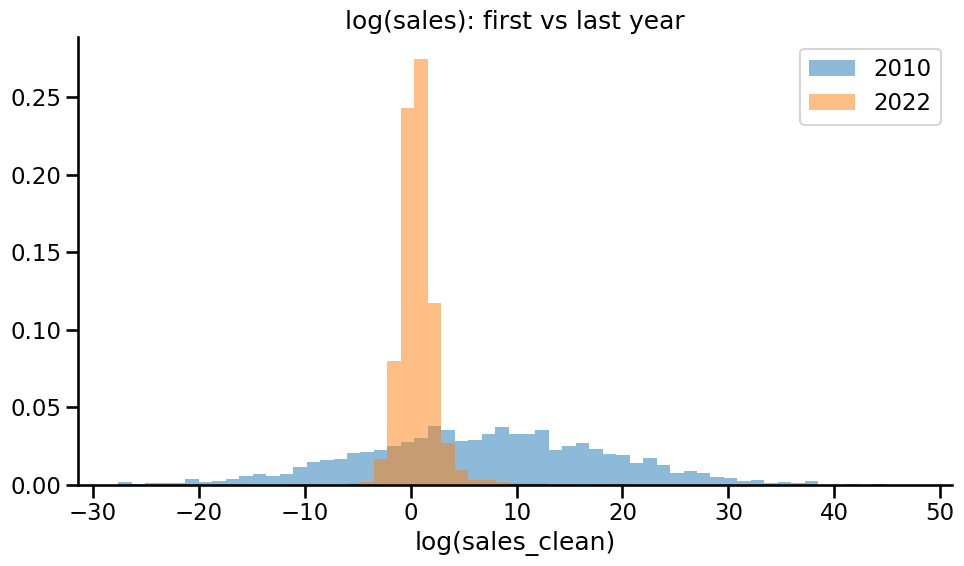

In [58]:
if sales in have:
    yA, yB = years[0], years[-1]
    dA = np.log(df.loc[df["year"]==yA, sales].clip(1e-12))
    dB = np.log(df.loc[df["year"]==yB, sales].clip(1e-12))
    bins = np.linspace(min(dA.min(), dB.min()), max(dA.max(), dB.max()), 60)
    plt.hist(dA, bins=bins, alpha=.5, density=True, label=str(yA))
    plt.hist(dB, bins=bins, alpha=.5, density=True, label=str(yB))
    plt.legend(); plt.xlabel("log(sales_clean)"); plt.title("log(sales): first vs last year")
    plt.tight_layout()

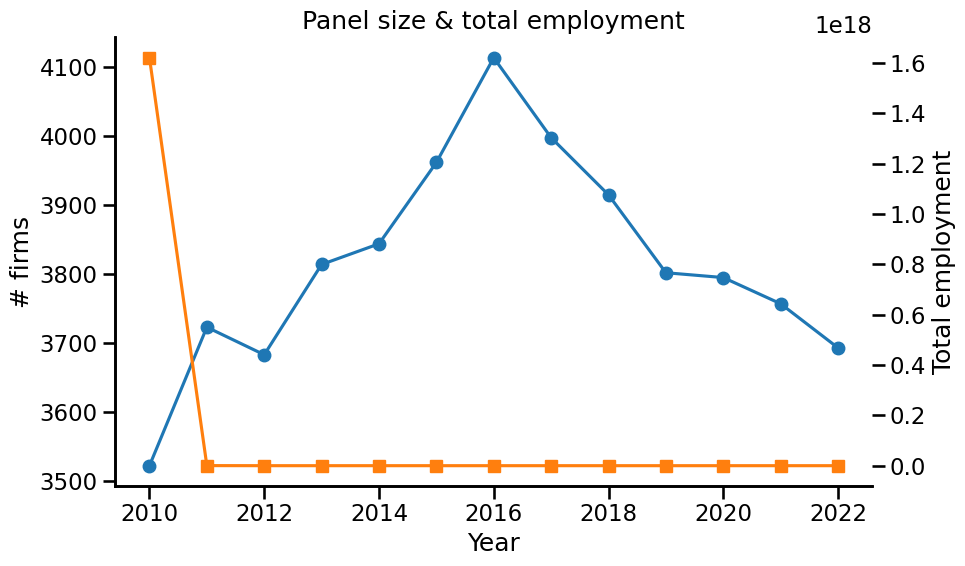

In [ ]:
fig, ax1 = plt.subplots()
n_by_y = df.groupby("year")["firm_id"].nunique()
ax1.plot(n_by_y.index, n_by_y.values, marker="o", label="# firms")
ax1.set_xlabel("Year"); ax1.set_ylabel("# firms")
ax2 = ax1.twinx()
if emp in have:
    emp_by_y = df.groupby("year")[emp].sum()
    ax2.plot(emp_by_y.index, emp_by_y.values, marker="s", color="tab:orange", label="total emp")
    ax2.set_ylabel("Total employment")
ax1.set_title("Panel size & total employment")
fig.tight_layout()
plt.show()

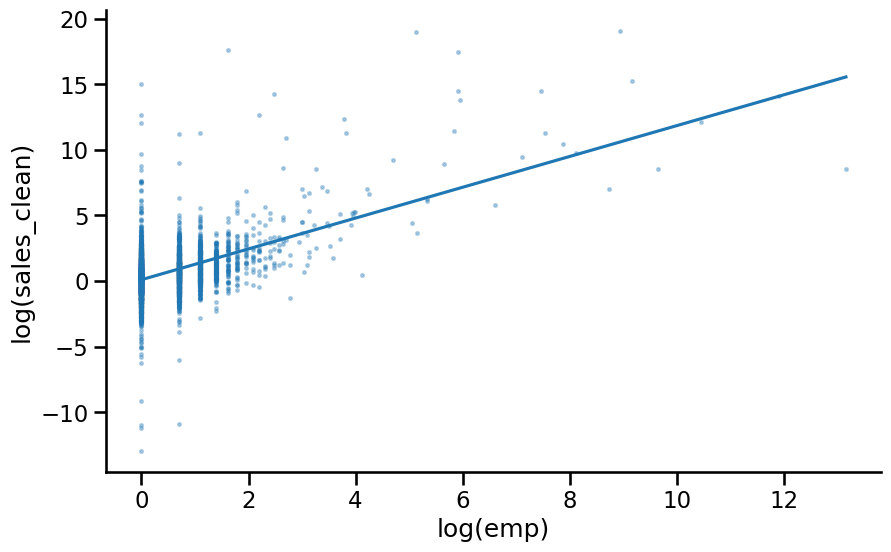

In [61]:
dy = df[df["year"]==df["year"].max()][["sales_clean","emp"]].dropna()
if len(dy) > 60000:
    dy = dy.sample(60000, random_state=0)

x = np.log(dy["emp"].clip(1))
y = np.log(dy["sales_clean"].clip(1e-12))

plt.figure()
plt.scatter(x, y, s=5, alpha=0.3)
m, b = np.polyfit(x, y, 1)
xs = np.linspace(x.min(), x.max(), 200)
plt.plot(xs, m*xs + b)
plt.xlabel("log(emp)")
plt.ylabel("log(sales_clean)")
plt.show()

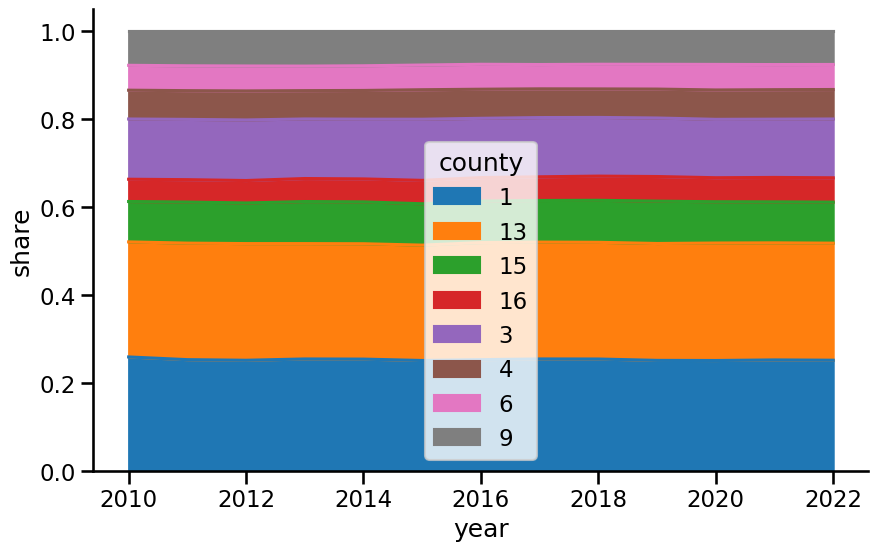

In [62]:
top = df["county"].value_counts().head(8).index
comp = (df[df["county"].isin(top)]
        .groupby(["year","county"])["firm_id"].nunique()
        .unstack(fill_value=0))
comp = comp.div(comp.sum(axis=1), axis=0)

comp.plot(kind="area")
plt.xlabel("year")
plt.ylabel("share")
plt.show()

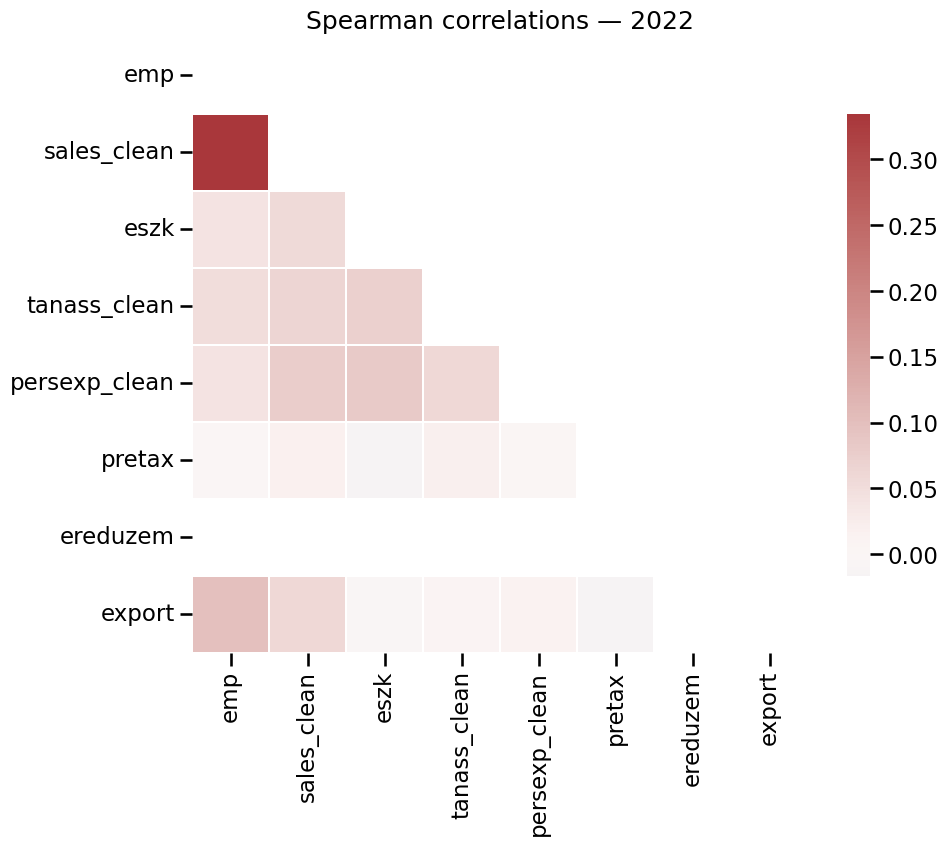

In [74]:
cand = [emp, sales, totA, tanA, perE, profit, ebit, exportv]
use = [c for c in cand if c in df.columns]
if use:
    dlast = df[df["year"]==int(years[-1])][use]
    if len(dlast) > 0:
        corr = dlast.corr(method="spearman")
        mask = np.triu(np.ones_like(corr, dtype=bool))
        plt.figure(figsize=(10,8))
        sns.heatmap(corr, mask=mask, cmap="vlag", center=0, square=True,
                    cbar_kws={"shrink": .75}, linewidths=.3, annot=False)
        plt.title(f"Spearman correlations — {years[-1]}")
        plt.show()